# Part I. ETL Pipeline for Pre-Processing the Files

## PLEASE RUN THE FOLLOWING CODE FOR PRE-PROCESSING THE FILES

#### Import Python packages 

In [1]:
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

%matplotlib inline

#### Creating list of filepaths to process original event csv data files

In [2]:
filepath = os.getcwd() + '/event_data'

for root, dirs, files in os.walk(filepath):    
    file_path_list = glob.glob(os.path.join(root,'*'))

#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [3]:
full_data_rows_list = [] 
    
for f in file_path_list:
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
        for line in csvreader:
            full_data_rows_list.append(line) 
            
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


In [4]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f) - 1)  # removing the header

6820


# Part II. Complete the Apache Cassandra coding portion of your project. 

## Now you are ready to work with the CSV file titled <font color=red>event_datafile_new.csv</font>, located within the Workspace directory.  The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>

<img src="images/image_event_datafile_new.jpg">

## Begin writing your Apache Cassandra code in the cells below

#### Creating a Cluster

In [5]:
from cassandra.cluster import Cluster
cluster = Cluster()

session = cluster.connect()

#### Create Keyspace

In [6]:
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS udacity 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

except Exception as e:
    print(e)

#### Set Keyspace

In [7]:
try:
    session.set_keyspace('udacity')
except Exception as e:
    print(e)

### Now we need to create tables to run the following queries. Remember, with Apache Cassandra you model the database tables on the queries you want to run.

## Create queries to ask the following three questions of the data

### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4


### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
    

### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'




---

To simulate the knowledge the Data Engineer should have over this data, I'm going to perform some exploration. Of course this could not be done with big data using these methods, this is just to simulate previous knowledge.

---

In [8]:
df = pd.read_csv('event_datafile_new.csv')

## Query 1

### Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0524fca90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0504f3b38>]], dtype=object)

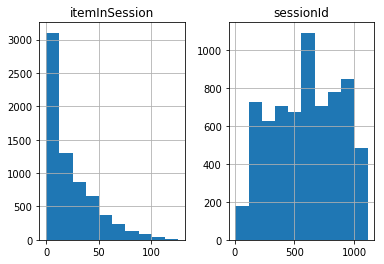

In [9]:
df[['sessionId', 'itemInSession']].hist()

As we can see the `sessionId` distribution is more uniform, so it makes a better Partition Key for the first query. The primary key for this query has to contain at least `itemInSession` as Clustering Column.

In [10]:
df[['sessionId', 'itemInSession']].drop_duplicates().index.size

6820

As there are no duplicates on this primary key we won't be needing more clustering columns.

In [11]:
query = """
CREATE TABLE IF NOT EXISTS song_in_session (
    session_id       int,
    item_in_session  int,
    artist           text,
    song             text,
    length           double,
    PRIMARY KEY      (session_id, item_in_session)
)
"""
try:
    session.execute(query)
except Exception as e:
    print(e)

In [12]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader)
    
    for line in csvreader:
        query = "INSERT INTO song_in_session (session_id, item_in_session, artist, song, length)"
        query = query + "VALUES (%s, %s, %s, %s, %s)"
        session.execute(query, (int(line[8]), int(line[3]), line[0], line[9], float(line[5])))

#### Do a SELECT to verify that the data have been inserted into each table

In [13]:
query = """
SELECT artist, song, length
FROM song_in_session
WHERE session_id=338 AND item_in_session=4
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (f'| {row.artist:20} | {row.song:40} | {row.length:20} |')

| Faithless            | Music Matters (Mark Knight Dub)          |             495.3073 |


---

## Query 2

### Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0503d42b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0503604e0>]], dtype=object)

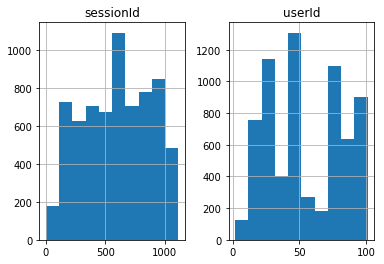

In [14]:
df[['sessionId', 'userId']].hist()

Same as before `sessionId` seems more uniform, but because of the query it's better to partition by `userId`, which also seems uniform. The primary key for this query has to contain at least `sessionId` as Clustering Column for the `WHERE` clause and `itemInSession` for the sorting. We already know this combination yields no duplicates.

In [15]:
query = """
CREATE TABLE IF NOT EXISTS sessions (
    user_id          int,
    session_id       int,
    item_in_session  int,
    artist           text,
    song             text,
    first_name       text,
    last_name        text,
    PRIMARY KEY      (user_id, session_id, item_in_session)
)
"""
try:
    session.execute(query)
except Exception as e:
    print(e)

In [16]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader)
    
    for line in csvreader:
        query = "INSERT INTO sessions (user_id, session_id, item_in_session, artist, song, first_name, last_name)"
        query = query + "VALUES (%s, %s, %s, %s, %s, %s, %s)"
        session.execute(query, (int(line[10]), int(line[8]), int(line[3]), line[0], line[9], line[1], line[4]))

#### Do a SELECT to verify that the data have been inserted into each table

In [17]:
query = """
SELECT artist, song, first_name, last_name
FROM sessions
WHERE user_id=10 AND session_id=182
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (f'| {row.artist:20} | {row.song:52} | {row.first_name + " " + row.last_name:20} |')

| Down To The Bone     | Keep On Keepin' On                                   | Sylvie Cruz          |
| Three Drives         | Greece 2000                                          | Sylvie Cruz          |
| Sebastien Tellier    | Kilometer                                            | Sylvie Cruz          |
| Lonnie Gordon        | Catch You Baby (Steve Pitron & Max Sanna Radio Edit) | Sylvie Cruz          |


---

## Query 3

### Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

The query suggests to use `song` as partition, this of course will require clustering columns to avoid duplicates. The only data we do not want duplicated is the user data, if a single user listens to the same song in multiple sessions we don't need to record each session for this use case. `userId` is the only clustering colum we need because of this.

In [18]:
query = """
CREATE TABLE IF NOT EXISTS user_songs (
    song             text,
    user_id          int,
    first_name       text,
    last_name        text,
    PRIMARY KEY      (song, user_id)
)
"""
try:
    session.execute(query)
except Exception as e:
    print(e)

In [19]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader)
    
    for line in csvreader:
        query = "INSERT INTO user_songs (song, user_id, first_name, last_name)"
        query = query + "VALUES (%s, %s, %s, %s)"
        session.execute(query, (line[9], int(line[10]), line[1], line[4]))

#### Do a SELECT to verify that the data have been inserted into each table

In [20]:
query = """
SELECT first_name, last_name
FROM user_songs
WHERE song='All Hands Against His Own'
"""
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print (row.first_name, row.last_name)

Jacqueline Lynch
Tegan Levine
Sara Johnson


---

### Drop the tables before closing out the sessions

In [21]:
try:
    session.execute('DROP TABLE IF EXISTS song_in_session')
except Exception as e:
    print(e)
    
try:
    session.execute('DROP TABLE IF EXISTS sessions')
except Exception as e:
    print(e)
    
try:
    session.execute('DROP TABLE IF EXISTS user_songs')
except Exception as e:
    print(e)

### Close the session and cluster connection¶

In [22]:
session.shutdown()
cluster.shutdown()